# ***Informacion del dataset***

In [318]:

%%html
<style> table { display: inline-block  }</style>

https://www.kaggle.com/datasets/riteshahlawat/covid19-mexico-patient-health-dataset



|col|0|1|97-98|
|---|---|---|---|
|sex|F|M|?|
|hospitalized|no|si|?|
|intubated|no|si|?|
|pneumonia|no|si|?|
|age|no|si|?|
|pregnant|no|si|?|
|diabetes|no|si|?|
|copd|no|si|?|
|asthma|no|si|?|
|immunosuppression|no|si|?|
|hypertension|no|si|?|
|other_diseases|no|si|?|
|cardiovascular|no|si|?|
|obesity|no|si|?|
|chronic_kidney_failure|no|si|?|
|smoker|no|si|?|
|another_case|no|si|?|
|outcome|no|si|?|
|icu|no|si|?|
|dead|no|si|?|

# **1. Importación de *modules***

In [319]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from numpy.ma.core import count

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")

import funciones as f

# **2. Importación del dataset *Patient.csv***


In [320]:
data = pd.read_csv("../data/patient.csv", sep = ",", low_memory=False) 
f._get_info(data)

   sex  patient_type  intubated  pneumonia  age  pregnant  diabetes  copd  \
0    2             1         97          2   42        97         2     2   
1    1             1         97          2   51         2         2     2   
2    2             2          2          2   51        97         1     2   

   asthma  immunosuppression  hypertension  other_diseases  cardiovascular  \
0       1                  2             2               2               2   
1       2                  2             2               2               2   
2       2                  2             1               2               2   

   obesity  chronic_kidney_failure  smoker  outcome  icu  death_date  
0        2                       2       2        1   97  9999-99-99  
1        2                       2       2        1   97  9999-99-99  
2        1                       2       2        1    2  9999-99-99  
(95252, 19)


# **3. Tratamiento de los datos**
Limpieza e imputaciones

### 3.1. Dropeo de columnas no informativas

In [321]:
#Dropeo icu, intubated, death_date
data=data.drop(['icu','intubated','death_date'], axis=1)
print(data.columns)
#f._get_info(data)
data.shape

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnant', 'diabetes',
       'copd', 'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'outcome'],
      dtype='object')


(95252, 16)

In [322]:
#99 a null y dropeo
cols=data.columns.difference(['age'])

df=(data[cols] == 99)
ix=df[df.any(axis=1)].index
print(ix)
data.drop(df.index[ix], axis=0, inplace=True)
data.shape


Int64Index([161, 174, 592, 609, 644, 13322, 15671, 27316], dtype='int64')


(95244, 16)

### 3.2. Renombre de columnas ambiguas
Por ejemplo, patient_type a inpatient, outcome a covid, etc

In [323]:
data.rename(columns={"patient_type": "inpatient", "outcome": "covid"},inplace=True)
data.columns

Index(['sex', 'inpatient', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid'],
      dtype='object')

Matriz de correlación para regresión logística

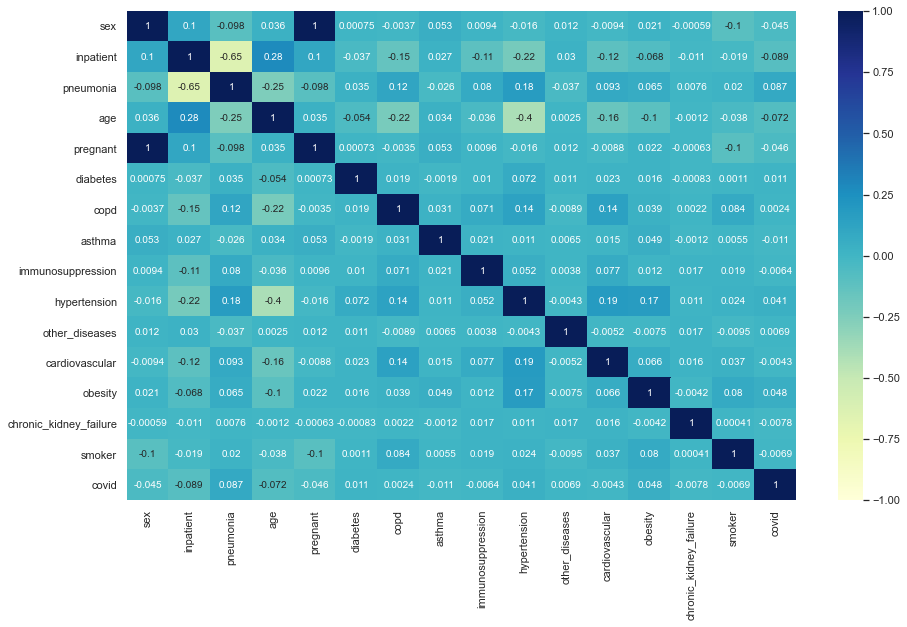

In [324]:
f._print_matriz_correlacion(data)

### 3.3 Conversión de datos 

#### 3.3.1 Conversión de datos para KNN

In [325]:
#creo un dataset sin dummies para knn
data_knn=data.copy()

In [326]:
#Para predictivas: 1 ->1 yes , 2 -> 0 no, 
cols = data_knn.loc[:, data_knn.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
data_knn[cols] = data_knn[cols].replace([2,98],[0,2])
#f._get_info(data_knn)

#en sex: 1 -> 1 F y 2-> 0 M
data_knn['sex'] = data_knn['sex'].replace([2],[0])
#f._get_info(data_knn)

#en pregnant : 98 -> 0, 97 -> 0
data_knn['pregnant'] = data_knn['pregnant'].replace([98,97],[0,0])
#f._get_info(data_knn,5)

# outcome: 3 -> 2 NA   1 -> 1 positivo     2->0 negativo
data_knn['covid'] = data_knn['covid'].replace([1,2,3],[1,0,2])
#f._get_info(data_knn)

##Para target (inpatient): 1 -> 0, 2 -> 1
data_knn['inpatient']= data_knn['inpatient'].replace([1,2],[0,1])
#f._get_info(data_knn)
data_knn.head(5)

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,0,0,0,42,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,51,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,51,0,1,0,0,0,1,0,0,1,0,0,1
3,0,1,0,57,0,1,0,0,0,0,0,0,0,0,0,1
4,1,1,0,44,0,1,0,0,0,0,0,0,0,0,0,0


In [327]:
df=data_knn.drop(['age'], axis=1)
df.apply(pd.value_counts)

,sex,inpatient,pneumonia,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,48354.0,69969.0,77816.0,94075,82400,92798.0,90930.0,92940.0,78582.0,90483,92273.0,79710.0,92948,85958.0,59505
1,46890.0,25275.0,17428.0,976,12810,2446.0,4314.0,2304.0,16662.0,4616,2971.0,15534.0,2277,9286.0,23182
2,NaN,NaN,NaN,193,34,NaN,NaN,NaN,NaN,145,NaN,NaN,19,NaN,12557


#### 3.3.2 Conversión de datos para BAYES

In [328]:
#Para predictivas: 1 -> Y, 2 -> N, 
cols = data.loc[:, data.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
data[cols] = data[cols].replace([1,2],['Y','N'])
#f._get_info(data)

#en sex: 1 -> F y 2-> M
data['sex']= data['sex'].replace([1,2],['F','M'])
#f._get_info(data)

#en pregnant : 98 -> N, 97 -> NA
data['pregnant'] = data['pregnant'].replace([98,97],['N','N'])
#f._get_info(data,5)

# outcome: 3 -> NA
data['covid'] = data['covid'].replace([3],['NOA'])
#f._get_info(data)

##Para target (inpatient): 1 -> 0, 2 -> 1
data['inpatient']= data['inpatient'].replace([1,2],[0,1])
#f._get_info(data)
data.head(5)

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,M,0,N,42,N,N,N,Y,N,N,N,N,N,N,N,Y
1,F,0,N,51,N,N,N,N,N,N,N,N,N,N,N,Y
2,M,1,N,51,N,Y,N,N,N,Y,N,N,Y,N,N,Y
3,M,1,N,57,N,Y,N,N,N,N,N,N,N,N,N,Y
4,F,1,N,44,N,Y,N,N,N,N,N,N,N,N,N,N


<AxesSubplot:>

[Text(0.5, 0, 'Columnas'), Text(0, 0.5, '% '), Text(0.5, 1.0, 'Datos ')]

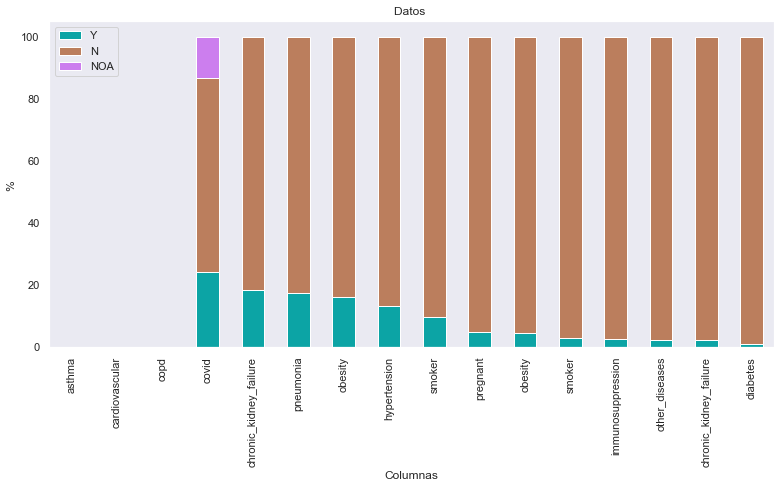

In [329]:
#cols_plt = data.loc[:, data.columns.difference(['age', 'sex','inpatient', 'covid'])].columns
cols_plt = data.loc[:, data.columns.difference(['age', 'sex'])].columns

# Creamos un nuevo dataframe para hacer el gráfico, sólo con dos columnas, % de nulos y no nulos por variable
val_yes = data.apply(lambda x: (x=='Y').sum() / data.shape[0] * 100)
val_not = data.apply(lambda x: (x=='N').sum() / data.shape[0] * 100)
val_na = data.apply(lambda x: (x=='NOA').sum() / data.shape[0] * 100)
#val_1 = data.apply(lambda x: (x=='1').count() / data.shape[0] * 100)
#sry_null = pd.DataFrame({'Y': val_yes, 'N': val_not ,'NA': val_na ,'1': val_1})
sry_null = pd.DataFrame({'Y': val_yes, 'N': val_not ,'NOA': val_na })

sns.set(style = 'dark')

fig, ax = plt.figure(figsize = (13, 6)), plt.axes()
sry_null.rename(index = cols_dict).sort_values(by = 'N').plot(kind = 'bar', stacked = True, color = ['#0CA4A5', '#BB7E5D' , '#CC7EEE','#0CccA5'], ax = ax)

ax.set(xlabel = 'Columnas', ylabel = '% ', title = 'Datos ')
ax.legend(loc = 'upper left')
# Guardo la imagen
#en colab
#images_dir = '/content/drive/My Drive/DSDH/TP1/Imagenes/null_barplot.png'
#en jupyter
plt.show()
#plt.savefig("null_barplot.png", dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)


In [330]:
######  ????????????????????????????
#data.apply(pd.value_counts(normalize=True))
df=data
s=df['sex'].value_counts(normalize=True)
c=df['copd'].value_counts(normalize=True)
p=df['pregnant'].value_counts(normalize=True)
co=df['covid'].value_counts(normalize=True)
Vinpatient=df['inpatient'].value_counts(normalize=True)

#s=df['sex'].value_counts()
#c=df['copd'].value_counts()
#p=df['pregnant'].value_counts()
#co=df['covid'].value_counts()
#co=df['asthma'].value_counts()


pd.DataFrame({'Inpatient':Vinpatient,'sex': s,'Covid': co})

,Inpatient,sex,Covid
0,0.734629,NaN,NaN
1,0.265371,NaN,NaN
F,NaN,0.492314,NaN
M,NaN,0.507686,NaN
N,NaN,NaN,0.624764
NOA,NaN,NaN,0.131840
Y,NaN,NaN,0.243396


### 3.4. Tabla de counts

In [331]:
data.groupby(["sex","pregnant"])["pregnant"].count()

sex  pregnant
F    N           45914
     Y             976
M    N           48354
Name: pregnant, dtype: int64

In [332]:
#cols = data.loc[:, data.columns.difference(['age'])].columns

#data.groupby(['inpatient','pregnant','copd'])['inpatient'].count()
#pd.pivot_table(data, index=[]'pregnant','diabetes'], columns='inpatient',   aggfunc='count')

### 3.5. Tabla pivot por inpatient

In [333]:
#creo un total count inpatient para ponderar resultados
total_inpatient = data['inpatient'].count()

#by sex
round(pd.pivot_table(data, values='inpatient', index=['sex'],
                     aggfunc=['count',(lambda x: count(x)/total_inpatient*100)]))

,count,<lambda>
,inpatient,inpatient
sex,,
F,46890,49.0
M,48354,51.0


In [334]:
total_inpatient = data['inpatient'].count()

print(lambda x: count(x)/total_inpatient*100)
#by sex
#round(pd.pivot_table(data, values='inpatient', index=['sex'],                  aggfunc=['count',]))

<function <lambda> at 0x00000190C3008A60>


In [335]:
#by diabetes
round(pd.pivot_table(data, values='inpatient', index=['diabetes','copd'],
                     aggfunc=['count',(lambda x: count(x)/total_inpatient*100)]))



count  <lambda>
              inpatient inpatient
diabetes copd                    
98       N           32       0.0
         Y            2       0.0
N        N        80914      85.0
         Y         1486       2.0
Y        N        11852      12.0
         Y          958       1.0

### 3.6. Creación de categorías a partir de edad

In [336]:
#creo categorias para edad por décadas 
data = data.assign(agegroup=pd.cut(data['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))
#pruedo crear categorías para edad por etapa de la vida
# como definimos? 0-18 niños, 18 a 30 jovenes, 30 a 60 Adultos, 60 a 80 adultos mayores, más de 80 ancianos?

In [337]:
data.columns

Index(['sex', 'inpatient', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

In [338]:
#elimino age para no tener dummies
data.drop(["age"], axis=1, inplace=True)

In [339]:
#chequeo que queden las columnas que quiero
data.columns

Index(['sex', 'inpatient', 'pneumonia', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

### 3.7. Creación de dummies

In [340]:
#creo variables dummies de todas las columnas menos la target
data = pd.get_dummies(data=data, columns= data.columns.difference(["inpatient"]),drop_first = True)

In [341]:
data.columns

Index(['inpatient', 'agegroup_10-19', 'agegroup_20-29', 'agegroup_30-39',
       'agegroup_40-49', 'agegroup_50-59', 'agegroup_60-69', 'agegroup_70-79',
       'agegroup_80-89', 'agegroup_90-99', 'asthma_Y', 'cardiovascular_Y',
       'chronic_kidney_failure_N', 'chronic_kidney_failure_Y', 'copd_Y',
       'covid_NOA', 'covid_Y', 'diabetes_N', 'diabetes_Y', 'hypertension_Y',
       'immunosuppression_Y', 'obesity_Y', 'other_diseases_N',
       'other_diseases_Y', 'pneumonia_Y', 'pregnant_Y', 'sex_M', 'smoker_Y'],
      dtype='object')

# **4. Exportación del dataset resultante a un nuevo *.csv***

In [342]:
# para exportar resultados
data.to_csv(r'../data/patient_covid.csv', index = False, header=True)
data.shape

data_knn.to_csv(r'../data/patient_covid_knn.csv', index = False, header=True)
data_knn.shape

(95244, 28)

(95244, 16)

In [343]:
data_knn

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,0,0,0,42,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,51,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,51,0,1,0,0,0,1,0,0,1,0,0,1
3,0,1,0,57,0,1,0,0,0,0,0,0,0,0,0,1
4,1,1,0,44,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95247,0,1,0,59,0,0,0,0,0,0,0,0,0,0,0,2
95248,0,1,0,50,0,1,0,0,1,1,0,0,0,1,0,2
95249,1,1,0,65,0,0,0,0,0,1,0,0,0,0,0,2
95250,1,0,0,48,0,0,0,0,0,0,0,0,0,0,0,2


In [344]:
data

,inpatient,agegroup_10-19,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_50-59,agegroup_60-69,agegroup_70-79,agegroup_80-89,agegroup_90-99,...,diabetes_Y,hypertension_Y,immunosuppression_Y,obesity_Y,other_diseases_N,other_diseases_Y,pneumonia_Y,pregnant_Y,sex_M,smoker_Y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95247,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
95248,1,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,0,0,0,1,0
95249,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
95250,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
